# SWMF Simulation vs. Observation Comparison

This notebook compares SWMF (Space Weather Modeling Framework) simulation results
against observational data for both **in-situ** (time-series) and **remote sensing** (EUV imagery) diagnostics.

**Inputs:**
- `run_dir`: Path to a specific simulation run (e.g., `Run_Max/run01`)
- Observational data in `obsdata/`

**Outputs:**
- Multi-panel in-situ comparison (Velocity, Density, Temperature, B-field) at Earth and STEREO-A
- Side-by-side EUV image comparison (synthetic AIA vs. observed AIA)

In [1]:
import swmf_viz as sv
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

# ============================================================
# CONFIGURATION — Change these to point to your run
# ============================================================
RESULTS_DIR = os.path.abspath('Results')          # Root of results
RUN_DIR     = 'Run_Min/run01'                     # Relative to RESULTS_DIR
AIA_CHANNEL = '193'                               # Primary AIA wavelength for comparison
CHANNELS    = ['131', '171', '193', '211', '304', '335']  # All channels for grid view

# Derived paths
run_path  = os.path.join(RESULTS_DIR, RUN_DIR)
obs_path  = os.path.join(RESULTS_DIR, 'obsdata')
ih_path   = os.path.join(run_path, 'IH')
sc_path   = os.path.join(run_path, 'SC')
param_file = os.path.join(run_path, 'PARAM.in')

print(f"Run directory : {run_path}")
print(f"Obs directory : {obs_path}")
print(f"PARAM.in      : {param_file} (exists={os.path.isfile(param_file)})")
print(f"EUV Channels  : {', '.join(CHANNELS)}")

Run directory : /home/zkeheng/SWMFSoftware/SWMFSOLAR/Results/Run_Min/run01
Obs directory : /home/zkeheng/SWMFSoftware/SWMFSOLAR/Results/obsdata
PARAM.in      : /home/zkeheng/SWMFSoftware/SWMFSOLAR/Results/Run_Min/run01/PARAM.in (exists=True)
EUV Channels  : 131, 171, 193, 211, 304, 335


## 1. Parse PARAM.in — Extract Simulation Start Time

In [2]:
event_time = sv.parse_start_time(param_file)
print(f"Event start time: {event_time}")
print(f"Formatted tag   : {event_time.strftime('%Y_%m_%dT%H_%M_%S')}")

Event start time: 2019-08-01 00:14:00
Formatted tag   : 2019_08_01T00_14_00


## 3. In-Situ Comparison — Time Series at Earth and STEREO-A

### 3a. Earth (OMNI) Comparison

SAT Earth : /home/zkeheng/SWMFSoftware/SWMFSOLAR/Results/Run_Min/run01/IH/trj_earth_n00005000.sat
OBS OMNI  : /home/zkeheng/SWMFSoftware/SWMFSOLAR/Results/obsdata/omni_2019_08_01T00_14_00.out


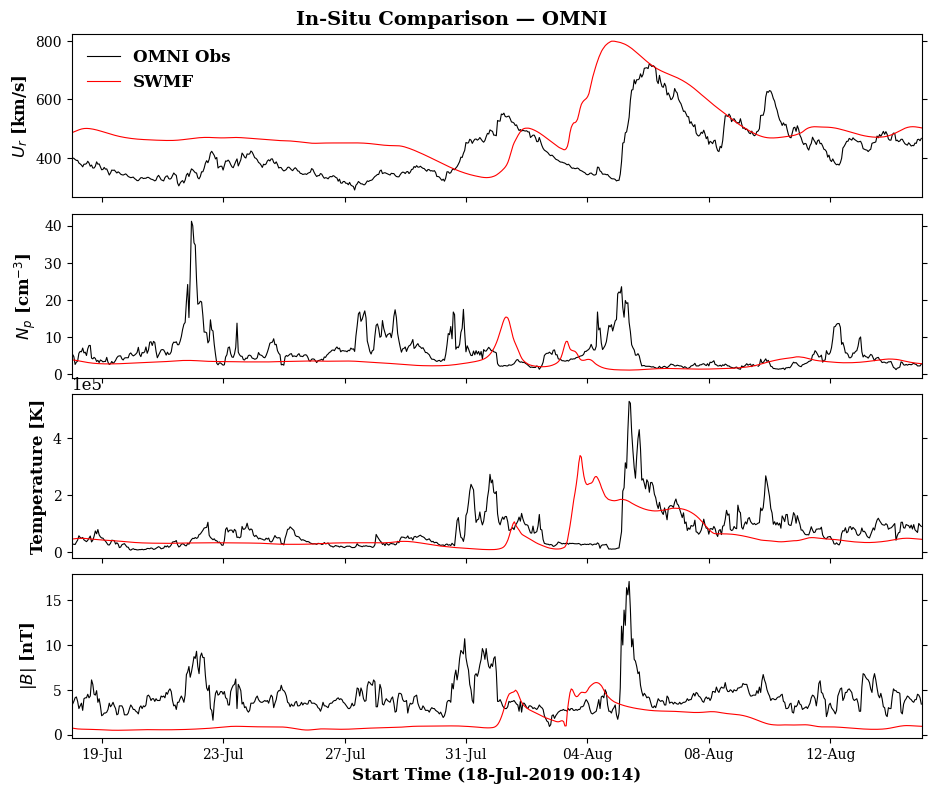

In [3]:
# --- Earth / OMNI ---
sat_earth_file = sv.find_sat_file(ih_path, 'earth')
obs_earth_file = sv.find_obs_file(obs_path, 'omni', event_time)

print(f"SAT Earth : {sat_earth_file}")
print(f"OBS OMNI  : {obs_earth_file}")

sim_earth = sv.read_sat_file(sat_earth_file) if sat_earth_file else None
obs_earth = sv.read_obs_file(obs_earth_file) if obs_earth_file else None

fig_earth = sv.plot_insitu_comparison(sim_earth, obs_earth, 'OMNI')
if fig_earth:
    plt.show()
    plot_filename = os.path.join(run_path, 'insitu_OMNI_comparison.pdf')
    # fig_earth.savefig(plot_filename, dpi=300, bbox_inches='tight')
    # print(f"Saved: {plot_filename}")

### 3b. STEREO-A Comparison

SAT STA : /home/zkeheng/SWMFSoftware/SWMFSOLAR/Results/Run_Min/run01/IH/trj_sta_n00005000.sat
OBS STA : /home/zkeheng/SWMFSoftware/SWMFSOLAR/Results/obsdata/sta_2019_08_01T00_14_00.out


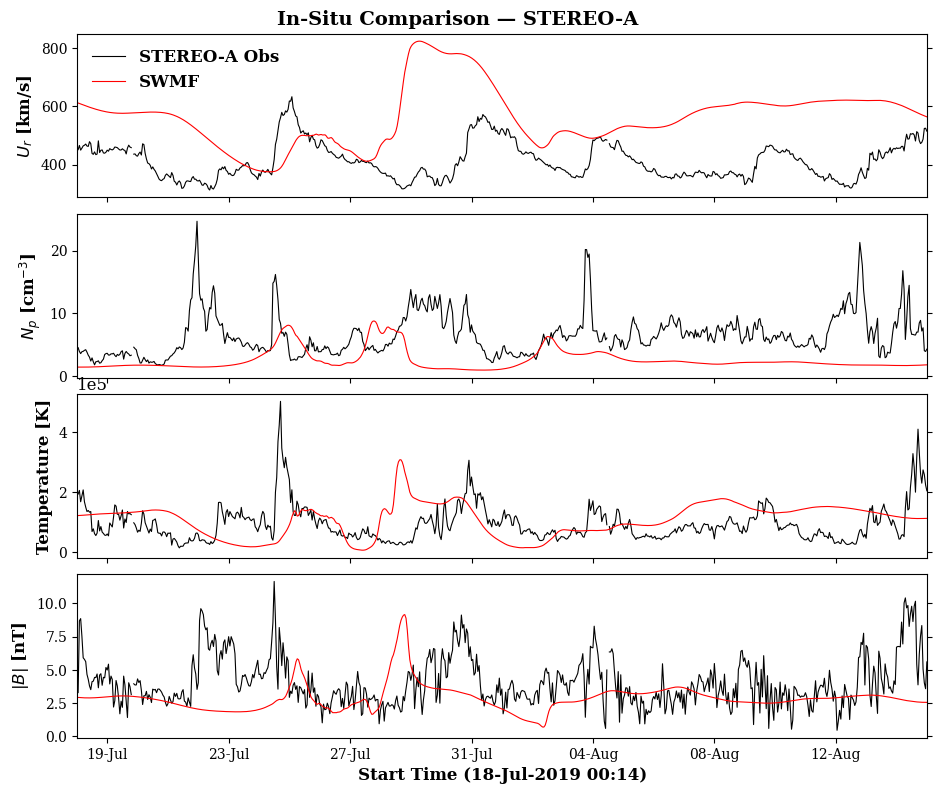

In [4]:
# --- STEREO-A ---
sat_sta_file = sv.find_sat_file(ih_path, 'sta')
obs_sta_file = sv.find_obs_file(obs_path, 'sta', event_time)

print(f"SAT STA : {sat_sta_file}")
print(f"OBS STA : {obs_sta_file}")

sim_sta = sv.read_sat_file(sat_sta_file) if sat_sta_file else None
obs_sta = sv.read_obs_file(obs_sta_file) if obs_sta_file else None

fig_sta = sv.plot_insitu_comparison(sim_sta, obs_sta, 'STEREO-A')
if fig_sta:
    plt.show()
    # plot_filename = os.path.join(run_path, 'insitu_STA_comparison.pdf')
    # fig_sta.savefig(plot_filename, dpi=300, bbox_inches='tight')
    # print(f"Saved: {plot_filename}")

## 2. Multi-Wavelength EUV Grid — Simulation and Observation

View multiple AIA channels simultaneously to understand the full coronal structure.
This section creates two grid plots:
1. **Synthetic SWMF images** across all wavelengths
2. **Observed AIA images** across all wavelengths

### 2a. Load Synthetic Multi-Wavelength Images

In [5]:
# --- Load synthetic LOS images for all channels ---
los_file = sv.find_los_file(sc_path, 'sdo_aia')

if los_file and os.path.isfile(los_file):
    print(f"Reading synthetic LOS file: {os.path.basename(los_file)}")
    print("Loading channels:", ', '.join(CHANNELS))
    
    sim_data_list = []
    sim_channels_list = []
    
    for channel in CHANNELS:
        x_sim, y_sim, img_sim = sv.read_los_file(los_file, channel)
        if img_sim is not None:
            sim_data_list.append((x_sim, y_sim, img_sim))
            sim_channels_list.append(channel)
            print(f"  ✓ AIA {channel}Å loaded (shape: {img_sim.shape})")
        else:
            print(f"  ✗ AIA {channel}Å not available")
    
    print(f"\nSuccessfully loaded {len(sim_data_list)}/{len(CHANNELS)} synthetic channels.")
else:
    print("No synthetic LOS file found.")
    sim_data_list = []
    sim_channels_list = []

Reading synthetic LOS file: los_sdo_aia_6_n00080000.out
Loading channels: 131, 171, 193, 211, 304, 335
  ✓ AIA 131Å loaded (shape: (512, 512))
  ✓ AIA 171Å loaded (shape: (512, 512))
  ✓ AIA 193Å loaded (shape: (512, 512))
  ✓ AIA 211Å loaded (shape: (512, 512))
  ✓ AIA 304Å loaded (shape: (512, 512))
  ✓ AIA 335Å loaded (shape: (512, 512))

Successfully loaded 6/6 synthetic channels.


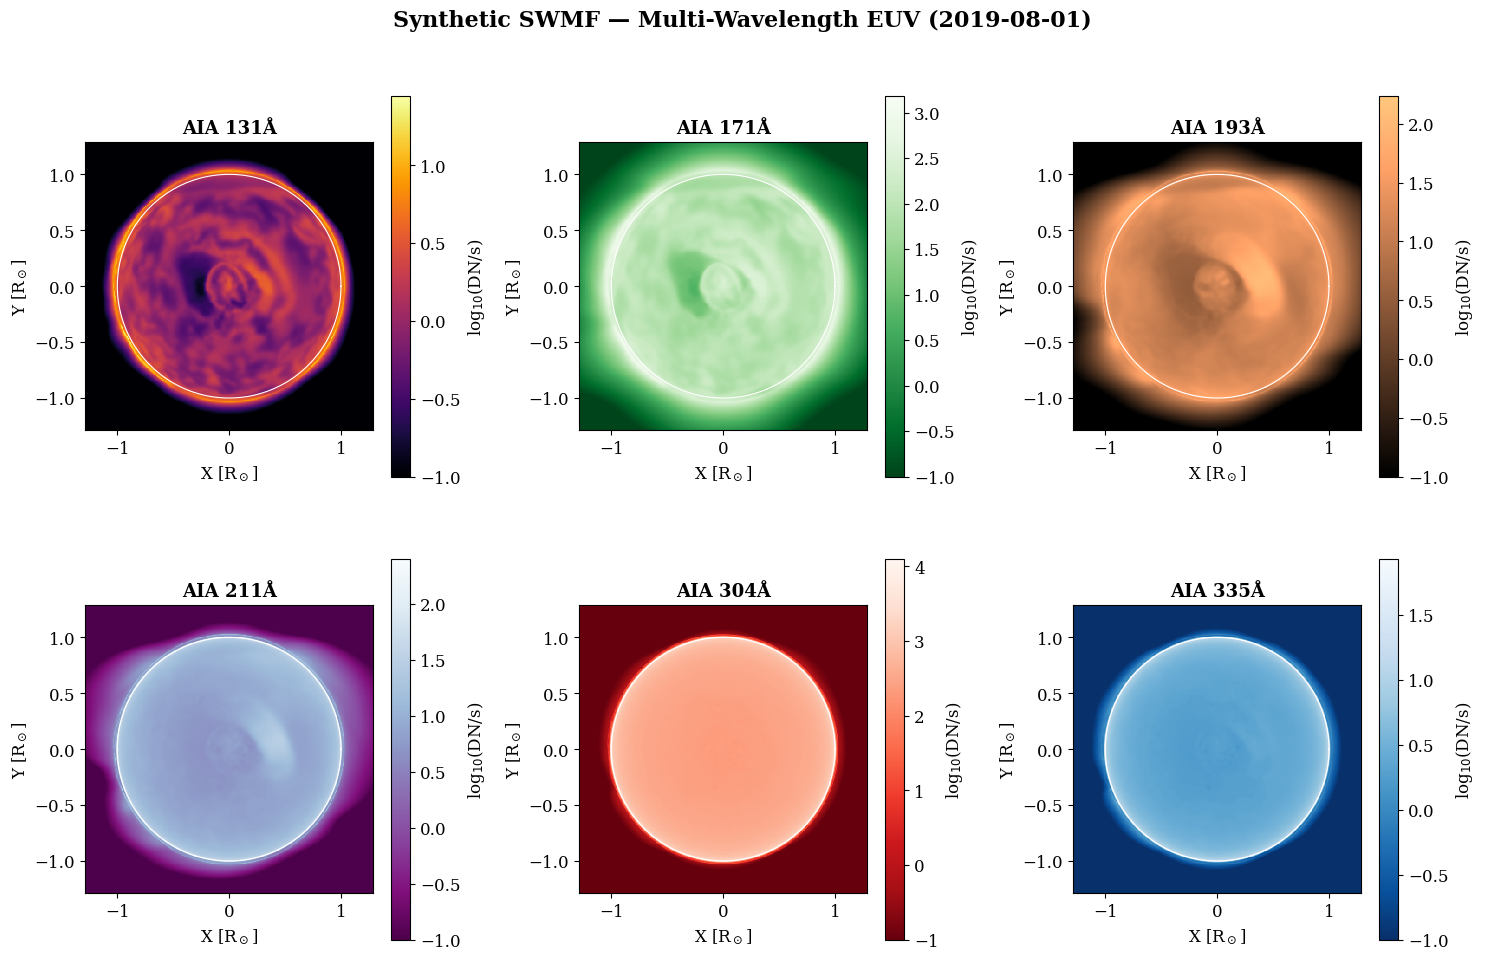

In [6]:
# --- Visualize synthetic multi-wavelength grid ---
if sim_data_list:
    fig_sim_grid = sv.visualize_euv_grid(
        sim_data_list, 
        sim_channels_list,
        title=f'Synthetic SWMF — Multi-Wavelength EUV ({event_time.strftime("%Y-%m-%d")})'
    )
    plt.show()
    # plot_filename = os.path.join(run_path, 'synthetic_multiwavelength_grid.pdf')
    # fig_sim_grid.savefig(plot_filename, dpi=300, bbox_inches='tight')
    # print(f"Saved: {plot_filename}")
else:
    print("No synthetic data to visualize.")

### 2b. Load Observed Multi-Wavelength Images

In [7]:
# --- Load observed AIA images for all channels ---
aia_obs_file = os.path.join(obs_path, 
    f"AIA_Observations_{event_time.strftime('%Y_%m_%dT%H_%M_%S')}.out")

if os.path.isfile(aia_obs_file):
    print(f"Reading AIA observation file: {os.path.basename(aia_obs_file)}")
    print("Loading channels:", ', '.join(CHANNELS))
    
    obs_data_list = []
    obs_channels_list = []
    
    for channel in CHANNELS:
        x_obs, y_obs, img_obs = sv.read_aia_obs_file(aia_obs_file, channel)
        if img_obs is not None:
            obs_data_list.append((x_obs, y_obs, img_obs))
            obs_channels_list.append(channel)
            print(f"  ✓ AIA {channel}Å loaded (shape: {img_obs.shape})")
        else:
            print(f"  ✗ AIA {channel}Å not available")
    
    print(f"\nSuccessfully loaded {len(obs_data_list)}/{len(CHANNELS)} observed channels.")
else:
    print(f"AIA observation file not found: {aia_obs_file}")
    print("Attempting to load individual FITS files...")
    
    obs_data_list = []
    obs_channels_list = []
    
    for channel in CHANNELS:
        fits_file = sv.find_aia_fits(obs_path, event_time, channel)
        if fits_file:
            img_obs = sv.read_aia_fits(fits_file)
            if img_obs is not None:
                # For FITS, we don't have coordinate arrays, so use None
                obs_data_list.append((None, None, img_obs))
                obs_channels_list.append(channel)
                print(f"  ✓ AIA {channel}Å FITS loaded")
        else:
            print(f"  ✗ AIA {channel}Å not found")
    
    print(f"\nSuccessfully loaded {len(obs_data_list)}/{len(CHANNELS)} observed channels.")

Reading AIA observation file: AIA_Observations_2019_08_01T00_14_00.out
Loading channels: 131, 171, 193, 211, 304, 335


  ✓ AIA 131Å loaded (shape: (512, 512))
  ✓ AIA 171Å loaded (shape: (512, 512))
  ✓ AIA 193Å loaded (shape: (512, 512))
  ✓ AIA 211Å loaded (shape: (512, 512))
  ✓ AIA 304Å loaded (shape: (512, 512))
  ✓ AIA 335Å loaded (shape: (512, 512))

Successfully loaded 6/6 observed channels.


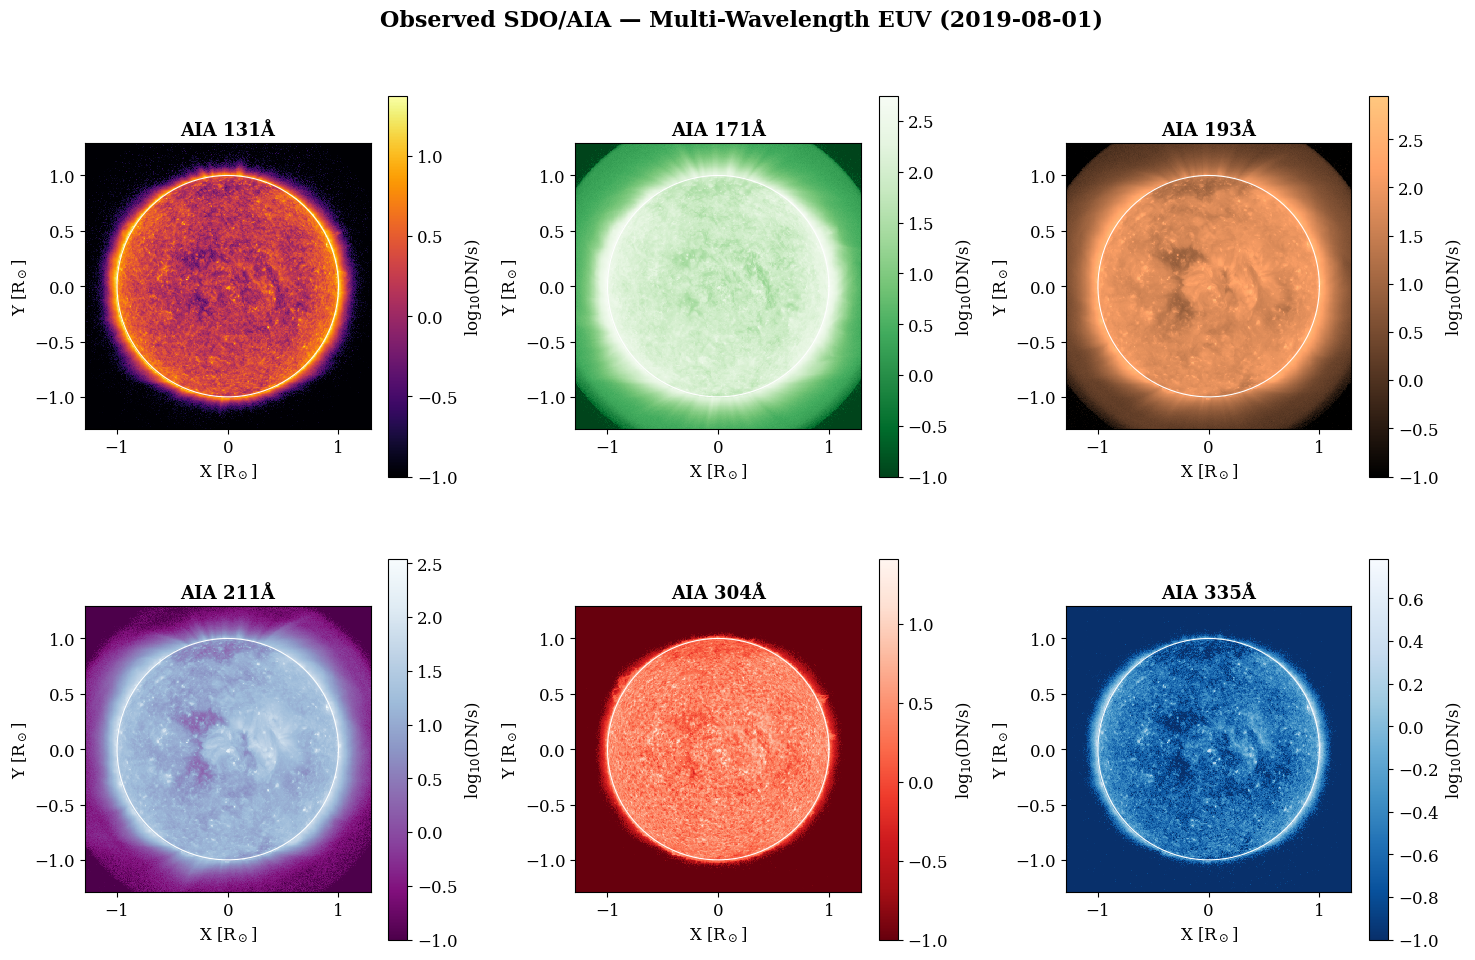

In [8]:
# --- Visualize observed multi-wavelength grid ---
if obs_data_list:
    fig_obs_grid = sv.visualize_euv_grid(
        obs_data_list, 
        obs_channels_list,
        title=f'Observed SDO/AIA — Multi-Wavelength EUV ({event_time.strftime("%Y-%m-%d")})'
    )
    plt.show()
    # plot_filename = os.path.join(run_path, 'observed_multiwavelength_grid.pdf')
    # fig_obs_grid.savefig(plot_filename, dpi=300, bbox_inches='tight')
    # print(f"Saved: {plot_filename}")
else:
    print("No observed data to visualize.")

## 3. Direct EUV Comparison — Side-by-Side Single Channel

Compare a specific wavelength channel (e.g., AIA 193Å) side-by-side between
synthetic SWMF and observed SDO/AIA. This provides a detailed, focused 
comparison at a single wavelength of interest.

### 3a. Load & Plot Direct EUV Comparison

In [9]:
# --- Locate files ---
channel = AIA_CHANNEL
cmap = sv.AIA_CMAPS.get(channel, 'hot')

los_file = sv.find_los_file(sc_path, 'sdo_aia')
aia_obs_file = os.path.join(obs_path, 
    f"AIA_Observations_{event_time.strftime('%Y_%m_%dT%H_%M_%S')}.out")
aia_fits_file = sv.find_aia_fits(obs_path, event_time, channel)

print(f"LOS  file  : {los_file}")
print(f"AIA obs    : {aia_obs_file} (exists={os.path.isfile(aia_obs_file)})")
print(f"AIA FITS   : {aia_fits_file}")
print(f"Channel    : AIA {channel}Å")
print(f"Colormap   : {cmap}")

LOS  file  : /home/zkeheng/SWMFSoftware/SWMFSOLAR/Results/Run_Min/run01/SC/los_sdo_aia_6_n00080000.out
AIA obs    : /home/zkeheng/SWMFSoftware/SWMFSOLAR/Results/obsdata/AIA_Observations_2019_08_01T00_14_00.out (exists=True)
AIA FITS   : /home/zkeheng/SWMFSoftware/SWMFSOLAR/Results/obsdata/aia.lev1.193A_2019-08-01T00_14_04.84Z.image_lev1.fits
Channel    : AIA 193Å
Colormap   : copper


In [10]:
# --- Read synthetic LOS image ---
x_sim, y_sim, img_sim = None, None, None
if los_file and os.path.isfile(los_file):
    print(f"Reading synthetic LOS file (this may take a moment for large files)...")
    x_sim, y_sim, img_sim = sv.read_los_file(los_file, channel)
    if img_sim is not None:
        print(f"  Synthetic image shape: {img_sim.shape}, "
              f"range: [{img_sim.min():.3e}, {img_sim.max():.3e}]")

# --- Read observation (prefer processed .out, fallback to FITS) ---
x_obs, y_obs, img_obs = None, None, None

if os.path.isfile(aia_obs_file):
    print(f"Reading AIA observation .out file...")
    x_obs, y_obs, img_obs = sv.read_aia_obs_file(aia_obs_file, channel)
    if img_obs is not None:
        print(f"  Obs image shape: {img_obs.shape}, "
              f"range: [{img_obs.min():.3e}, {img_obs.max():.3e}]")
elif aia_fits_file:
    print(f"Reading AIA FITS file...")
    img_obs_raw = sv.read_aia_fits(aia_fits_file)
    if img_obs_raw is not None:
        img_obs = img_obs_raw
        print(f"  Obs FITS shape: {img_obs.shape}, "
              f"range: [{img_obs.min():.3e}, {img_obs.max():.3e}]")
else:
    print("  No observation EUV data found.")

Reading synthetic LOS file (this may take a moment for large files)...


  Synthetic image shape: (512, 512), range: [0.000e+00, 1.734e+02]
Reading AIA observation .out file...
  Obs image shape: (512, 512), range: [-3.047e+00, 8.897e+02]


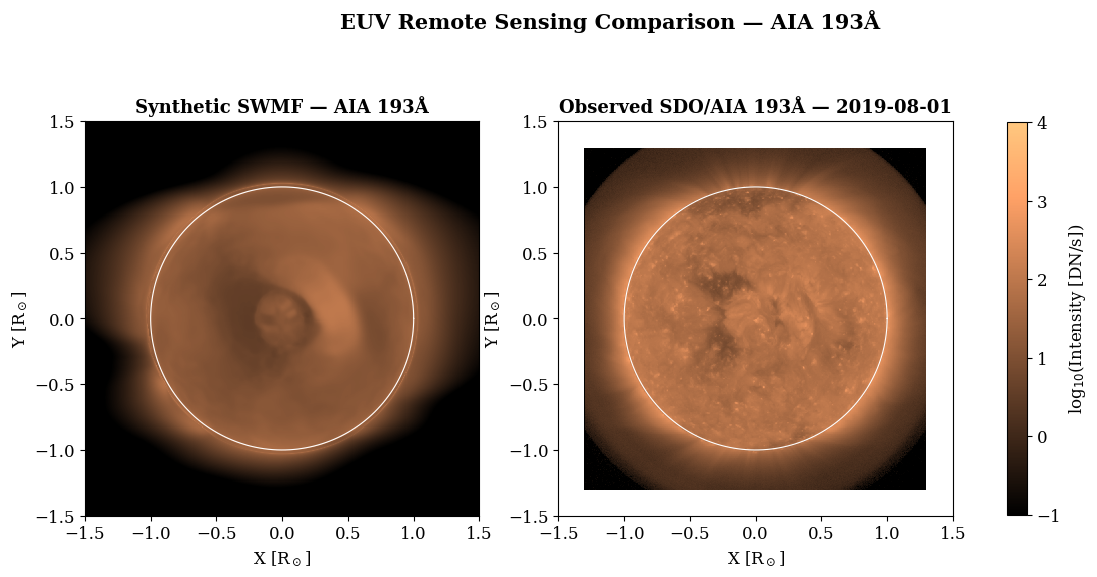

In [11]:
# --- Side-by-side EUV Comparison Plot ---
if img_sim is not None or img_obs is not None:
    sim_data = (x_sim, y_sim, img_sim)
    obs_data = (x_obs, y_obs, img_obs)
    
    fig_euv = sv.plot_remote_comparison(sim_data, obs_data, channel, event_time, cmap=cmap)
    plt.show()
    # plot_filename = os.path.join(run_path, f'remote_AIA{channel}_comparison.pdf')
    # fig_euv.savefig(plot_filename, dpi=300, bbox_inches='tight')
    # print(f"Saved: {plot_filename}")
else:
    print("No EUV data available for comparison.")

## 3b. Multi-Wavelength Direct Comparison Grid

Create a comprehensive multi-row comparison grid showing simulation vs. observation
for all wavelengths simultaneously. Each wavelength pair (sim/obs) is vertically stacked
and uses observation-based dynamic scaling.

In [12]:
# --- Define wavelengths for comprehensive comparison ---
# COMPARISON_CHANNELS = ['94', '131', '171', '193', '211', '304', '335']
COMPARISON_CHANNELS = ['94', '131', '171', '193', '211', '304']

print(f"Preparing multi-wavelength comparison for {len(COMPARISON_CHANNELS)} channels...")
print(f"Channels: {', '.join(COMPARISON_CHANNELS)}")

# --- Collect simulation data for all channels ---
sim_comparison_list = []
sim_comparison_channels = []

if los_file and os.path.isfile(los_file):
    for ch in COMPARISON_CHANNELS:
        x_s, y_s, img_s = sv.read_los_file(los_file, ch)
        if img_s is not None:
            sim_comparison_list.append((x_s, y_s, img_s))
            sim_comparison_channels.append(ch)
            print(f"  ✓ Sim {ch}Å loaded")
        else:
            # Add placeholder for missing data
            sim_comparison_list.append((None, None, None))
            sim_comparison_channels.append(ch)
            print(f"  ✗ Sim {ch}Å not available")
else:
    print("  [WARNING] No synthetic LOS file available")

# --- Collect observation data for all channels ---
obs_comparison_list = []
obs_comparison_channels = []

# Try processed .out file first
if os.path.isfile(aia_obs_file):
    for ch in COMPARISON_CHANNELS:
        x_o, y_o, img_o = sv.read_aia_obs_file(aia_obs_file, ch)
        if img_o is not None:
            obs_comparison_list.append((x_o, y_o, img_o))
            obs_comparison_channels.append(ch)
            print(f"  ✓ Obs {ch}Å loaded from .out")
        else:
            # Try FITS fallback
            fits_f = sv.find_aia_fits(obs_path, event_time, ch)
            if fits_f:
                img_o_fits = sv.read_aia_fits(fits_f)
                if img_o_fits is not None:
                    obs_comparison_list.append((None, None, img_o_fits))
                    obs_comparison_channels.append(ch)
                    print(f"  ✓ Obs {ch}Å loaded from FITS")
                else:
                    obs_comparison_list.append((None, None, None))
                    obs_comparison_channels.append(ch)
                    print(f"  ✗ Obs {ch}Å not available")
            else:
                obs_comparison_list.append((None, None, None))
                obs_comparison_channels.append(ch)
                print(f"  ✗ Obs {ch}Å not found")
else:
    # Fallback to individual FITS files
    print("  Attempting to load from individual FITS files...")
    for ch in COMPARISON_CHANNELS:
        fits_f = sv.find_aia_fits(obs_path, event_time, ch)
        if fits_f:
            img_o_fits = sv.read_aia_fits(fits_f)
            if img_o_fits is not None:
                obs_comparison_list.append((None, None, img_o_fits))
                obs_comparison_channels.append(ch)
                print(f"  ✓ Obs {ch}Å loaded from FITS")
            else:
                obs_comparison_list.append((None, None, None))
                obs_comparison_channels.append(ch)
                print(f"  ✗ Obs {ch}Å failed to read")
        else:
            obs_comparison_list.append((None, None, None))
            obs_comparison_channels.append(ch)
            print(f"  ✗ Obs {ch}Å not found")

print(f"\nData collection complete!")
print(f"  Simulation: {sum(1 for x,y,img in sim_comparison_list if img is not None)}/{len(COMPARISON_CHANNELS)} channels")
print(f"  Observation: {sum(1 for x,y,img in obs_comparison_list if img is not None)}/{len(COMPARISON_CHANNELS)} channels")

Preparing multi-wavelength comparison for 6 channels...
Channels: 94, 131, 171, 193, 211, 304
  ✓ Sim 94Å loaded
  ✓ Sim 131Å loaded
  ✓ Sim 171Å loaded
  ✓ Sim 193Å loaded
  ✓ Sim 211Å loaded
  ✓ Sim 304Å loaded
  ✓ Obs 94Å loaded from .out
  ✓ Obs 131Å loaded from .out
  ✓ Obs 171Å loaded from .out
  ✓ Obs 193Å loaded from .out
  ✓ Obs 211Å loaded from .out
  ✓ Obs 304Å loaded from .out

Data collection complete!
  Simulation: 6/6 channels
  Observation: 6/6 channels


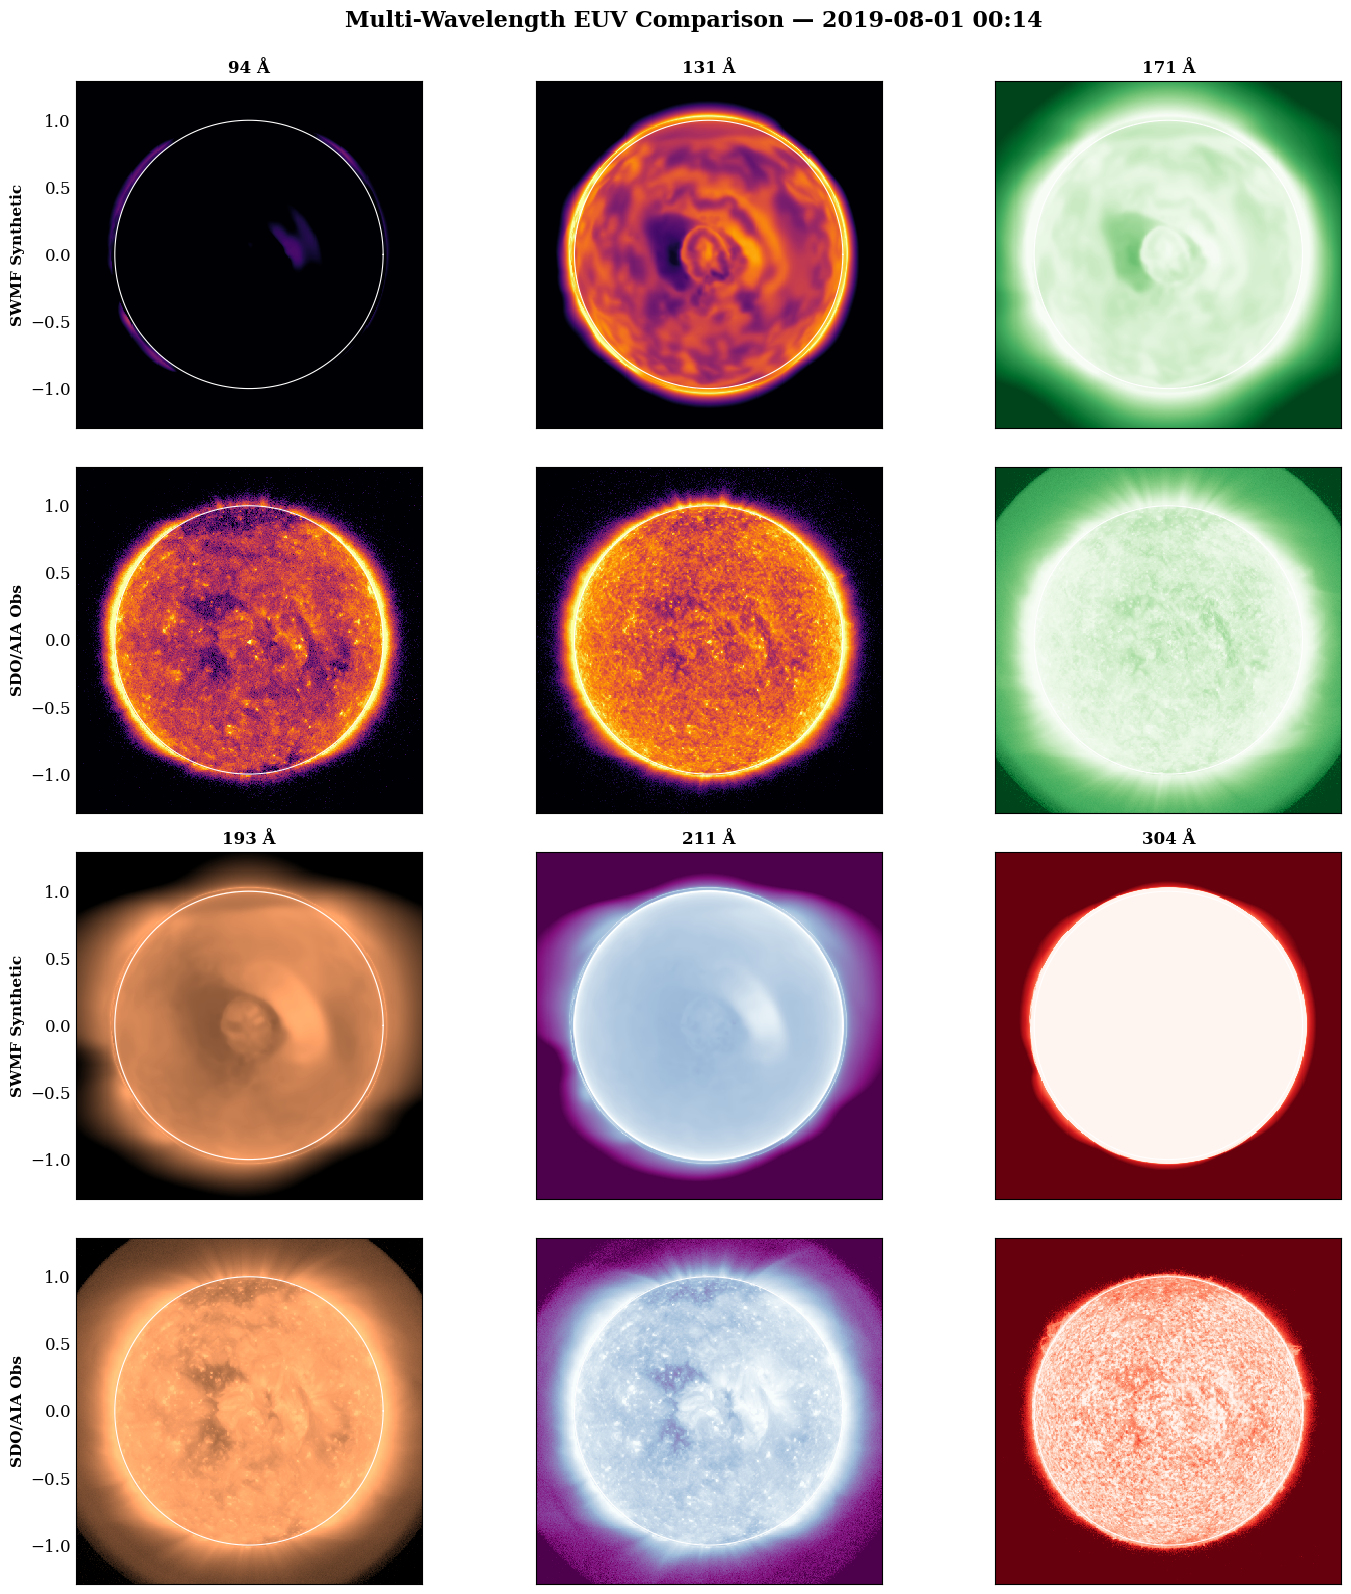

In [13]:
# --- Create multi-wavelength comparison grid ---
if len(sim_comparison_list) > 0 and len(obs_comparison_list) > 0:
    fig_wavelength_grid = sv.plot_wavelength_comparison_grid(
        sim_comparison_list,
        obs_comparison_list,
        COMPARISON_CHANNELS,
        event_time,
        max_cols=3  # 3 columns per row, will wrap to multiple blocks if needed
    )
    
    if fig_wavelength_grid:
        plt.show()
        # Optionally save the figure
        # plot_filename = os.path.join(run_path, 'wavelength_comparison_grid.pdf')
        # fig_wavelength_grid.savefig(plot_filename, dpi=300, bbox_inches='tight')
        # print(f"Saved: {plot_filename}")
else:
    print("Insufficient data for wavelength comparison grid.")

## 4. Quantitative Metrics

Display normalized distance metrics between simulation and observation (if available in the run directory).

In [14]:
# Find metrics files (CR*_omni.txt and CR*_sta.txt)
metric_files = glob.glob(os.path.join(run_path, 'CR*_omni.txt'))
metric_files += glob.glob(os.path.join(run_path, 'CR*_sta.txt'))

if metric_files:
    print("=" * 55)
    print(f"{'Metric File':<30s} {'Dist_U':>7s} {'Dist_N':>7s} {'Dist_T':>7s} {'Dist_B':>7s}")
    print("-" * 55)
    for mf in sorted(metric_files):
        m = sv.read_metrics_file(mf)
        if m:
            name = os.path.basename(mf)
            print(f"{name:<30s} {m.get('Dist_U',np.nan):7.4f} "
                  f"{m.get('Dist_N',np.nan):7.4f} "
                  f"{m.get('Dist_T',np.nan):7.4f} "
                  f"{m.get('Dist_B',np.nan):7.4f}")
    print("=" * 55)
    print("(Lower values indicate better agreement with observations)")
else:
    print("No metrics files (CR*_omni.txt / CR*_sta.txt) found in run directory.")

Metric File                     Dist_U  Dist_N  Dist_T  Dist_B
-------------------------------------------------------
CR2220_omni.txt                 0.1259  0.1046  0.0759  0.1690
CR2220_sta.txt                  0.2722  0.1498  0.0940  0.1498
(Lower values indicate better agreement with observations)


## 5. Multi-Run Comparison (Optional)

Compare multiple runs side-by-side (e.g., `Run_Max`, `Run_Max_R`, `Run_Min`).

Available runs: ['Run_Max/run01', 'Run_Max_R/run01', 'Run_Min/run01']

Comparing 2 runs for event date 2024-08-01


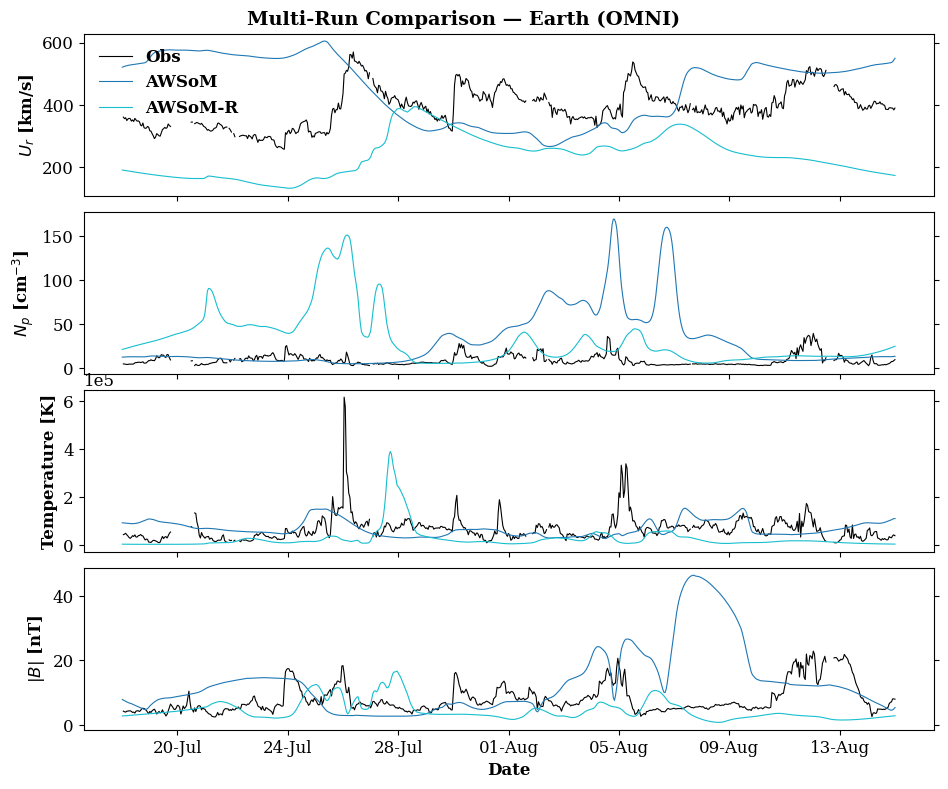

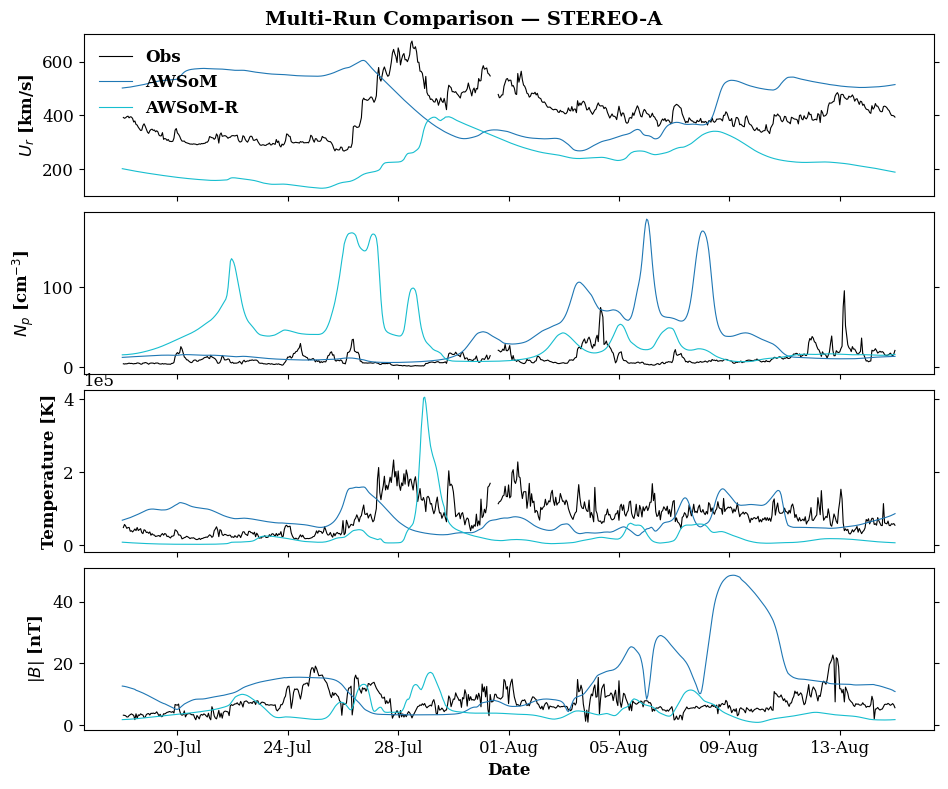


Only one run for 2019-08-01, skipping multi-run comparison.


In [15]:
import matplotlib.dates as mdates

def compare_runs_insitu(run_dirs, spacecraft='earth', obs_prefix='omni',
                       labels=None, colors=None):
    """Overlay in-situ results from multiple runs on a single plot.

    Parameters
    ----------
    run_dirs : list of str
        Relative run paths (e.g., ['Run_Max/run01', 'Run_Max_R/run01']).
    spacecraft : str
        'earth' or 'sta'.
    obs_prefix : str
        'omni' for Earth, 'sta' for STEREO-A.
    """
    if labels is None:
        labels = [os.path.basename(os.path.dirname(r)) for r in run_dirs]
    if colors is None:
        colors = plt.cm.tab10(np.linspace(0, 1, len(run_dirs)))

    fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
    ylabels = [r'$U_r$ [km/s]', r'$N_p$ [cm$^{-3}$]',
               r'Temperature [K]', r'$|B|$ [nT]']

    obs_plotted = False

    for i, (rd, label, color) in enumerate(zip(run_dirs, labels, colors)):
        rp = os.path.join(RESULTS_DIR, rd)
        pf = os.path.join(rp, 'PARAM.in')
        if not os.path.isfile(pf):
            print(f"  [SKIP] {pf} not found")
            continue

        et = sv.parse_start_time(pf)
        sat_f = sv.find_sat_file(os.path.join(rp, 'IH'), spacecraft)
        sim = sv.read_sat_file(sat_f) if sat_f else None

        # Plot observation only once (from first valid run)
        if not obs_plotted:
            obs_f = sv.find_obs_file(obs_path, obs_prefix, et)
            obs = sv.read_obs_file(obs_f) if obs_f else None
            if obs is not None:
                axes[0].plot(obs['date'], obs['V_tot'], 'k-', lw=0.8, label='Obs')
                axes[1].plot(obs['date'], obs['Rho'],   'k-', lw=0.8)
                axes[2].plot(obs['date'], obs['Temperature'], 'k-', lw=0.8)
                axes[3].plot(obs['date'], obs['B_tot'], 'k-', lw=0.8)
                obs_plotted = True

        if sim is not None:
            axes[0].plot(sim['date'], sim['ur'],    color=color, lw=0.8, label=label)
            axes[1].plot(sim['date'], sim['ndens'], color=color, lw=0.8)
            axes[2].plot(sim['date'], sim['ti'],    color=color, lw=0.8)
            axes[3].plot(sim['date'], sim['bmag'],  color=color, lw=0.8)

    for i, ax in enumerate(axes):
        ax.set_ylabel(ylabels[i], fontsize=12, fontweight='bold')
        ax.yaxis.set_ticks_position('both')
    axes[2].ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    axes[3].xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    axes[3].xaxis.set_major_locator(plt.MaxNLocator(8))
    axes[3].set_xlabel('Date', fontsize=12, fontweight='bold')
    axes[0].legend(frameon=False, fontsize=10, loc='upper left',
                   prop={'weight': 'bold'})
    sc_name = 'Earth (OMNI)' if spacecraft == 'earth' else 'STEREO-A'
    fig.suptitle(f'Multi-Run Comparison — {sc_name}', fontsize=14, fontweight='bold')
    plt.subplots_adjust(left=0.12, bottom=0.08, right=0.97, top=0.95, hspace=0.1)
    return fig

# --- Compare all available runs at Earth ---
available_runs = []
for run_parent in ['Run_Max', 'Run_Max_R', 'Run_Min']:
    rd = os.path.join(run_parent, 'run01')
    if os.path.isdir(os.path.join(RESULTS_DIR, rd)):
        available_runs.append(rd)

print(f"Available runs: {available_runs}")

if len(available_runs) > 1:
    # Group by event time (only compare runs with the same start date)
    run_groups = {}
    for rd in available_runs:
        pf = os.path.join(RESULTS_DIR, rd, 'PARAM.in')
        et = sv.parse_start_time(pf)
        key = et.strftime('%Y-%m-%d')
        run_groups.setdefault(key, []).append(rd)

    for date_key, runs in run_groups.items():
        if len(runs) > 1:
            print(f"\nComparing {len(runs)} runs for event date {date_key}")
            fig = compare_runs_insitu(runs, 'earth', 'omni', labels=['AWSoM', 'AWSoM-R'])
            plt.show()

            fig2 = compare_runs_insitu(runs, 'sta', 'sta', labels=['AWSoM', 'AWSoM-R'])
            plt.show()

            fig.savefig(os.path.join(run_path, f'multi_run_comparison_{date_key}_earth.pdf'),
                        dpi=300, bbox_inches='tight')
            fig2.savefig(os.path.join(run_path, f'multi_run_comparison_{date_key}_sta.pdf'),
                        dpi=300, bbox_inches='tight')
        else:
            print(f"\nOnly one run for {date_key}, skipping multi-run comparison.")
else:
    print("Only one run available, skipping multi-run comparison.")

## 7. Binary 2D Slice Visualization

Read and visualize binary SWMF 2D slice files (e.g., `z=0_var_3_n00080000.out`)

In [16]:
# Example: Read a binary 2D slice file
# Replace this path with an actual file from your simulation output
slice_file = 'Results/Run_Max_R/run01/SC/z=0_var_3_n00080000.out'

# Check if the file exists (this is just an example path)
import os
if os.path.exists(slice_file):
    # Read the binary file
    data = sv.read_swmf_binary_2d(slice_file)
    
    if data is not None:
        # Print available variables
        print("Available variables:")
        for key in data.keys():
            if key not in ['X', 'Y', '_metadata']:
                print(f"  - {key}")
        
        # Print metadata
        print("\nMetadata:")
        for key, val in data['_metadata'].items():
            print(f"  {key}: {val}")
else:
    print(f"Example file not found: {slice_file}")
    print("\nTo use this reader, provide the path to a binary SWMF 2D slice file.")
    print("Example files: z=0_var_3_n*.out, y=0_var_3_n*.out, etc.")

  [WARNING] Record marker mismatch: 20 vs -2
  [WARNING] Record marker mismatch: 4 vs 20
  [ERROR] Failed to read dimension info from Results/Run_Max_R/run01/SC/z=0_var_3_n00080000.out


In [17]:
# Example: Visualize density (Rho) with logarithmic scaling
# Uncomment and modify when you have a real data file

# if data is not None:
#     # Plot density
#     fig = swmf_viz.plot_swmf_2d_slice(
#         data=data,
#         var_name='Rho',
#         log_scale=True,
#         cmap='plasma',
#         title='Density Distribution in $z=0$ Plane'
#     )
#     plt.show()
#     
#     # Plot temperature
#     fig = swmf_viz.plot_swmf_2d_slice(
#         data=data,
#         var_name='T',
#         log_scale=True,
#         cmap='hot',
#         title='Temperature Distribution in $z=0$ Plane'
#     )
#     plt.show()

print("Visualization examples ready (uncomment when you have data loaded)")

Visualization examples ready (uncomment when you have data loaded)


### Usage Notes

The binary reader handles **Fortran unformatted binary** files automatically:

- **Record markers** are parsed transparently
- **Coordinate arrays** are reshaped to 2D grids
- **Variable data** is correctly oriented (ny × nx)
- **Metadata** includes time, dimensions, and variable names

**Common variables:**
- `Rho`: Mass density [use log scale]
- `T`: Temperature [use log scale]
- `Ux`, `Uy`, `Uz`: Velocity components [linear or log]
- `Bx`, `By`, `Bz`: Magnetic field components
- `P`: Pressure [use log scale]

**Typical file patterns:**
- `z=0_var_3_n00080000.out` - Equatorial plane
- `y=0_var_3_n00080000.out` - Meridional plane
- `x=0_var_3_n00080000.out` - Meridional plane